In [1]:
# CS 194-26 Final Project #2 Image Quilting
# Authors: Glenn Wysen and Morgan Nanez

In [52]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage
from skimage import io, transform, color, filters
import numpy as np
import matplotlib.pyplot as plt
import functools
import random
import cv2
from skimage.color import rgb2gray
import numba
from scipy.ndimage.filters import convolve

In [3]:
text_tex = io.imread('samples/text_small.jpg') / 255
brick_tex = io.imread('samples/bricks_small.jpg') / 255
white_tex = io.imread('samples/white_small.jpg') / 255

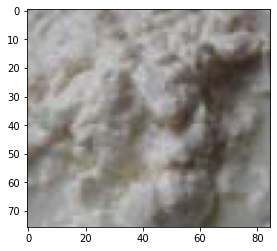

In [4]:
plt.imshow(white_tex)
plt.rcParams['figure.figsize'] = [6, 6]
plt.show()

In [5]:
def quilt_random(sample, outsize, patchsize):
    # Randomly samples squares of size patchsize from sample and tiles them into an output image of size outsize
    assert patchsize < min(sample.shape[:2]), 'Patch size larger than input sample texture'
    output = np.zeros((outsize))
    offsetY_range = int(sample.shape[0] - patchsize)
    offsetX_range = int(sample.shape[1] - patchsize)
    for y in range(outsize[0] // patchsize):
        for x in range(outsize[1] // patchsize):
            offsetY = int(np.floor(random.random() * offsetY_range))
            offsetX = int(np.floor(random.random() * offsetX_range))
            patch = sample[offsetY:offsetY + patchsize, offsetX:offsetX + patchsize]
            output[y * patchsize:y * patchsize + patchsize, x * patchsize:x * patchsize + patchsize] = patch
    return output     

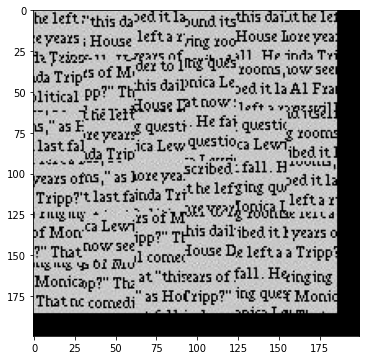

In [6]:
# good white_tex params
# big_size = [150, 150, 3]
# patchsize = 25
# texture = white_tex

# good brick_tex params
# big_size = [250, 250, 3]
# patchsize = 49
# texture = brick_tex

# good text_tex params
big_size = [200, 200, 3]
patchsize = 31
texture = text_tex


rand_quilt = quilt_random(texture, big_size, patchsize)
plt.imshow(rand_quilt)
# plt.savefig('random.jpg')
plt.show()

In [7]:
def generate_costs_both(sample, output_patch, overlap):
    patch_size = output_patch.shape[0]
    # starting 999 value chosen for filtering out bad points later
    costmap = np.ones((sample.shape[0], sample.shape[1])) * 999
    for y in range(patch_size // 2, sample.shape[0] - patch_size // 2):
        for x in range(patch_size // 2, sample.shape[1] - patch_size // 2):
            test_patch = sample.copy()[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            test_patch[overlap:, overlap:] = [0, 0, 0]
            diff = test_patch - output_patch
            cost = np.sum(diff**2)
            costmap[y, x] = cost
    mincost = np.min(costmap[costmap >= 0])
    return costmap, mincost

In [8]:
def generate_costs_left(sample, output_patch, overlap):
    patch_size = output_patch.shape[0]
    # starting 999 value chosen for filtering out bad points later
    costmap = np.ones((sample.shape[0], sample.shape[1])) * 999
    for y in range(patch_size // 2, sample.shape[0] - patch_size // 2):
        for x in range(patch_size // 2, sample.shape[1] - patch_size // 2):
            test_patch = sample.copy()[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            test_patch[:, overlap:] = [0, 0, 0]
            diff = test_patch - output_patch
#             plt.imshow(test_patch)
#             plt.show()
#             plt.imshow(output_patch)
#             plt.show()
            cost = np.sum(diff**2)
            costmap[y, x] = cost
    mincost = np.amin(costmap)
    return costmap, mincost

In [9]:
def generate_costs_top(sample, output_patch, overlap):
    patch_size = output_patch.shape[0]
    # starting 999 value chosen for filtering out bad points later
    costmap = np.ones((sample.shape[0], sample.shape[1])) * 999
    for y in range(patch_size // 2, sample.shape[0] - patch_size // 2):
        for x in range(patch_size // 2, sample.shape[1] - patch_size // 2):
            test_patch = sample.copy()[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            test_patch[overlap:, :] = [0, 0, 0]
            diff = test_patch - output_patch
            cost = np.sum(diff**2)
            costmap[y, x] = cost
    mincost = np.min(costmap[costmap >= 0])
    return costmap, mincost

In [10]:
def quilt_simple(sample, outsize, patchsize, overlap, tol):
    assert patchsize % 2 == 1, 'Patchsize must be odd in order to sample based off the center'
    output = np.zeros((outsize))
    
    # Placing a random patch into the top left
    offsetY = int(np.floor(random.random() * (sample.shape[0] - patchsize)))
    offsetX = int(np.floor(random.random() * (sample.shape[1] - patchsize)))
    
#     offsetY = 0
#     offsetX = 0
    
    rand_patch = sample[offsetY:offsetY + patchsize, offsetX:offsetX + patchsize]
    output[0: patchsize, 0:patchsize] = rand_patch 
    for y in range(0, outsize[0] // (patchsize - overlap)):
        for x in range(0, outsize[1] // (patchsize - overlap)):
            if y == 0 and x == 0:
                continue
            ymin = y * (patchsize - overlap)
            ymax = y * (patchsize - overlap) + patchsize
            xmin = x * (patchsize - overlap)
            xmax = x * (patchsize - overlap) + patchsize

            patch = output[ymin:ymax, xmin:xmax]
  
            if y == 0:
                costmap, mincost = generate_costs_left(sample, patch, overlap)
            elif x == 0:
                costmap, mincost = generate_costs_top(sample, patch, overlap)
            else:
                costmap, mincost = generate_costs_both(sample, patch, overlap)
                
            good_points = costmap < max(mincost * (1 + tol), .1)
            good_centers = np.transpose(good_points.nonzero())
#             print(len(good_centers))
            rand_center = good_centers[np.random.randint(len(good_centers))]
            fill_patch = sample[rand_center[0] - patchsize // 2:rand_center[0] + patchsize // 2 + 1, 
                                rand_center[1] - patchsize // 2:rand_center[1] + patchsize // 2 + 1]
            output[ymin:ymax, xmin:xmax] = fill_patch
#             plt.imshow(output)
#             plt.show()
    return output

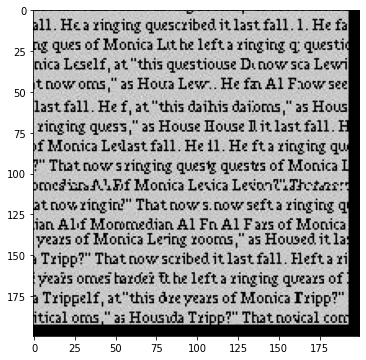

In [11]:
# good white_tex params
# big_size = [150, 150, 3]
# patchsize = 25
# overlap = 3
texture = white_tex

# good brick_tex params
# big_size = [250, 250, 3]
# patchsize = 49
# overlap = 5
# texture = brick_tex

# good text_tex params
big_size = [200, 200, 3]
patchsize = 31
overlap = 4
texture = text_tex

better_quilt = quilt_simple(texture, big_size, patchsize, overlap, .1)
plt.imshow(better_quilt)
# plt.savefig('overlap.jpg')
plt.show()

In [69]:
# code for seam finding adapted from https://karthikkaranth.me/blog/implementing-seam-carving-with-python/
def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map

def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index -1
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((r, c), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M
    j = np.argmin(M[-1])

    
    for i in range(r):
        # Mark the pixels for deletion
        mask[r - i - 1, j] = False
        j = backtrack[r - i - 1, j]

    plt.imshow(mask)
    plt.show()
    return
    # Since the image has 3 channels, we convert our
    # mask to 3D
    mask = np.stack([mask] * 3, axis=2)


    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    img = img[mask].reshape((r, c - 1, 3))

    return img

def carve_row(img):
    img = np.rot90(img, 1, (0, 1))
    img = carve_column(img)
    img = np.rot90(img, 3, (0, 1))
    return img

In [ ]:
def quilt_cut(sample, outsize, patchsize, overlap, tol):
    assert patchsize % 2 == 1, 'Patchsize must be odd in order to sample based off the center'
    output = np.zeros((outsize))
    
    # Placing a random patch into the top left
    offsetY = int(np.floor(random.random() * (sample.shape[0] - patchsize)))
    offsetX = int(np.floor(random.random() * (sample.shape[1] - patchsize)))
    
#     offsetY = 0
#     offsetX = 0
    
    rand_patch = sample[offsetY:offsetY + patchsize, offsetX:offsetX + patchsize]
    output[0: patchsize, 0:patchsize] = rand_patch 
    for y in range(0, outsize[0] // (patchsize - overlap)):
        for x in range(0, outsize[1] // (patchsize - overlap)):
            if y == 0 and x == 0:
                continue
            ymin = y * (patchsize - overlap)
            ymax = y * (patchsize - overlap) + patchsize
            xmin = x * (patchsize - overlap)
            xmax = x * (patchsize - overlap) + patchsize

            patch = output[ymin:ymax, xmin:xmax]
  
            if y == 0:
                costmap, mincost = generate_costs_left(sample, patch, overlap)
            elif x == 0:
                costmap, mincost = generate_costs_top(sample, patch, overlap)
            else:
                costmap, mincost = generate_costs_both(sample, patch, overlap)
                
            good_points = costmap < max(mincost * (1 + tol), .1)
            good_centers = np.transpose(good_points.nonzero())
#             print(len(good_centers))
            rand_center = good_centers[np.random.randint(len(good_centers))]
            fill_patch = sample[rand_center[0] - patchsize // 2:rand_center[0] + patchsize // 2 + 1, 
                                rand_center[1] - patchsize // 2:rand_center[1] + patchsize // 2 + 1]
        
        
            orig_mask, fill_mask = 
            output[ymin:ymax, xmin:xmax] = orig_mask * patch + fill_mask * fill_patch
#             plt.imshow(output)
#             plt.show()
    return output